In [1]:
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.robust.robust_linear_model import RLM
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

# Set the seed
np.random.seed(508)

# **Over-Reliance on Normality**
Author: Moamen Abdelkawy

## **Definition**

**In an AR(n) model for a time series (as an example for a time series model), $X_t$ can be formulated as:**

**$$X_t = \phi_0 + \phi_1 X_{t-1} + \phi_2 X_{t-2} + ... + \phi_n X_{t-n} + \epsilon_t$$**

where:
- $X_t$ is the value of the time series at time \(t\),
- $\phi_0$ is the intercept term,
- $\phi_1, \phi_2, ..., \phi_n$ are the coefficients for the \(n\) lagged values of the series, and
- $\epsilon_t$ is the error term at time $t$.

**Over-reliance on normality occurs when the model assumes that:**

**$$X_t \sim N(\mu, \sigma^2) \lor \epsilon_t \sim N(0, \sigma^2_\epsilon)$$**

**But the actual distributions are not Gaussian:**

**$$X_t \not\sim N(\mu, \sigma^2) \lor \epsilon_t \not\sim N(0, \sigma^2_\epsilon)$$**

## **Description**

In time series analysis, over-reliance on normality refers to the false assumption that either the underlying data or the residuals of the model follow a Gaussian or normal distribution. While this assumption simplifies the modeling process, real-life data, particularly economic and financial data, frequently deviate from this assumption, exhibiting skewness, heavy tails, and other non-normal characteristics. This can lead to significant inaccuracies in interpreting real-world phenomena, and low model predictive power [[1]](https://discovery.ucl.ac.uk/id/eprint/10070182/1/Schmidt_UCL_depos_JCE2018.pdf) [[2]](https://sujithjay.com/normality-assumption).

## **Demonstration**

This analysis simulates returns data with fat tails using a t-distribution, which is often used as an alternative to the normal distribution for financial returns due to its heavier tails [[3]](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=65037).

In [2]:
# Simulate returns data with fat tails
data_fat_tails = stats.t.rvs(df=3, loc=0, scale=1, size=1000)

Either a histogram with normal distribution overlay, or a Q-Q plot, can visually demonstrate the deviation from normality.

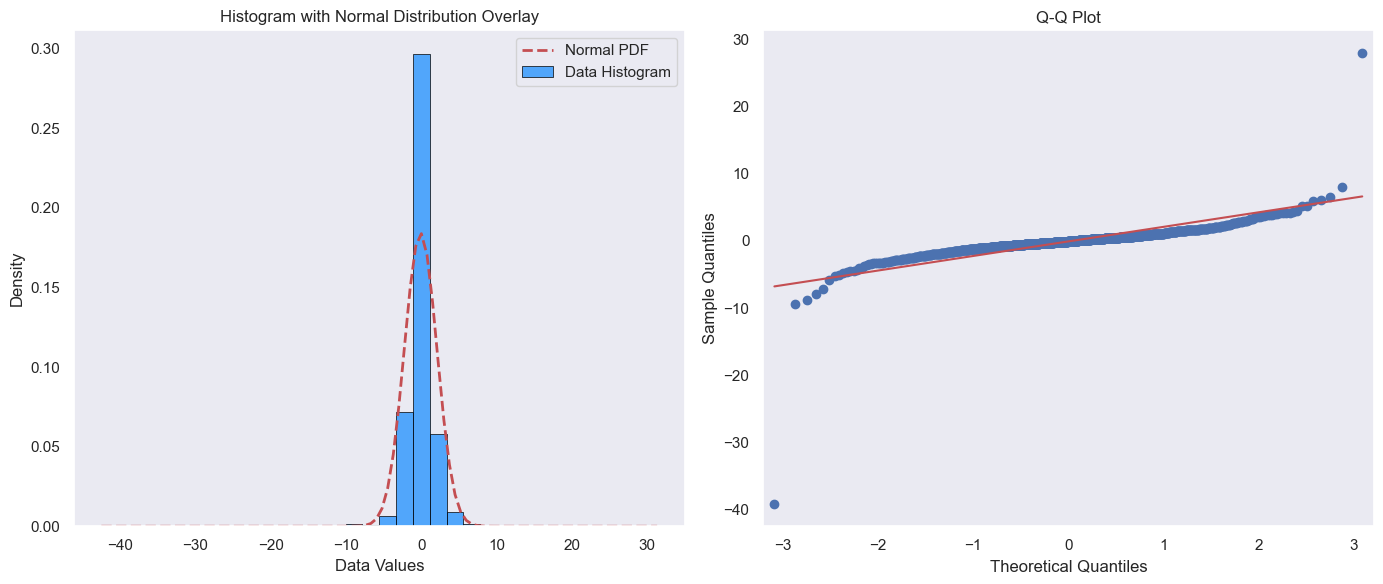

In [3]:
# Setting up Seaborn style and color palette
sns.set(style='dark', palette='deep')

# Create figure for plotting
plt.figure(figsize=(14, 6))

# Histogram with Normal Distribution Overlay
plt.subplot(1, 2, 1)
sns.histplot(data_fat_tails, kde=False, color="dodgerblue", stat="density", bins=30, edgecolor='black', linewidth=0.5, label='Data Histogram')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(data_fat_tails), np.std(data_fat_tails))
plt.plot(x, p, 'r--', linewidth=2, label='Normal PDF')
plt.title('Histogram with Normal Distribution Overlay')
plt.xlabel('Data Values')
plt.ylabel('Density')
plt.legend()

# Q-Q Plot
plt.subplot(1, 2, 2)
qqplot(data_fat_tails, line='s', ax=plt.gca())
plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()

Both plots clearly shows that the underlying data is not normally distributed.The distribution is left skewed and heavily leptokurtic. The exact values for both the skewness and kurtosis are calculated below.

In [4]:
print(f"Skewness: {stats.skew(data_fat_tails)}")
print(f"Kurtosis: {stats.kurtosis(data_fat_tails, fisher=False)}")  # Fisher=False for traditional kurtosis

Skewness: -3.773134905821561
Kurtosis: 135.6806928488361


## **Diagnose**

There are several methods to test for normality [[4]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3693611/). This analysis will focus on three popular tests:
- Jarque-Bera Test
- Shapiro-Wilk Test
- Anderson-Darling Test

### **Jarque-Bera Test**

The Jarque-Bera test is a goodness-of-fit test of whether sample data have the skewness and kurtosis matching a normal distribution [[5]](https://www.econstor.eu/bitstream/10419/49919/1/668828234.pdf). This test is particularly popular with financial data where large sample sizes are common.

- **Null Hypothesis $H_0$**: The data follows a normal distribution.
  
$$H_0: X \sim N(\mu, \sigma^2)$$

- **Alternative Hypothesis $H_1$**: The data does not follow a normal distribution.
  
  $$H_1: X \not\sim N(\mu, \sigma^2)$$

In [5]:
# Jarque-Bera Test

jb_stat, jb_p = stats.jarque_bera(data_fat_tails)
print(f"Jarque-Bera Test: Stat={jb_stat:.2f}, p-value={jb_p:.2g}")
print("Normality rejected by Jarque-Bera" if jb_p < 0.05 else "Jarque-Bera: Normality not rejected")

Jarque-Bera Test: Stat=735879.69, p-value=0
Normality rejected by Jarque-Bera


A significant p-value (typically < 0.05) suggests the data does not follow a normal distribution. This is the case with this dataset.

### **Shapiro-Wilk Test**

This is one of the most powerful and widely used tests for assessing the normality of a dataset. It evaluates whether a sample comes from a normally distributed population [[6]](https://builtin.com/data-science/shapiro-wilk-test).

- **Null Hypothesis $H_0$**: The data follows a normal distribution.
  
$$H_0: X \sim N(\mu, \sigma^2)$$

- **Alternative Hypothesis $H_1$**: The data does not follow a normal distribution.
  
  $$H_1: X \not\sim N(\mu, \sigma^2)$$

In [6]:
# Shapiro-Wilk test
shapiro = stats.shapiro(data_fat_tails)
print(f"Shapiro-Wilk: Stat={shapiro[0]:.2f}, p-value={shapiro[1]:.2g}")
print("Normality rejected by Shapiro-Wilk" if shapiro[1] < 0.05 else "Shapiro-Wilk: Normality not rejected")

Shapiro-Wilk: Stat=0.61, p-value=2e-42
Normality rejected by Shapiro-Wilk


The p-value is significant in this test (< 0.05), indicating non-normality.

### **Anderson-Darling test**

Anderson-Darling test is used to test if a sample of data came from a population with a specific distribution. This test is a modification of the Kolmogorov-Smirnov (K-S) test, as it gives more weight to the tails [[7]](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35e.htm).

In the case of testing for normality, the hypothesis are as follows:

- **Null Hypothesis $H_0$**: The data follows a normal distribution.
  
$$H_0: X \sim N(\mu, \sigma^2)$$

- **Alternative Hypothesis $H_1$**: The data does not follow a normal distribution.
  
  $$H_1: X \not\sim N(\mu, \sigma^2)$$

In [7]:
# Anderson-Darling test
anderson = stats.anderson(data_fat_tails, dist='norm')
print(f"Anderson-Darling: Stat={anderson.statistic:.2f}")
level, crit = anderson.significance_level, anderson.critical_values
print("Normality rejected by Anderson-Darling at the following levels:")
for l, c in zip(level, crit):
    if anderson.statistic > c:
        print(f"{l}%")
    else:
        print(f"{l}%: Normality not rejected")

Anderson-Darling: Stat=52.07
Normality rejected by Anderson-Darling at the following levels:
15.0%
10.0%
5.0%
2.5%
1.0%


The test rejects the null hypothesis of normality on every significance level.

## **Damage**

### **Misrepresentation of Tail Risks**

Over-reliance on normality can lead to underestimation of extreme events, which are more common in fat-tailed data than a normal distribution would suggest. This misrepresentation by the assumed normal distribution can lead to a significant underestimation of risk. 

To illustrate this, this analysis compares Value at Risk (VaR) for the fat-tailed data and a normally distributed data.

In [8]:
# Simulate normally distributed returns
data_normal = stats.norm.rvs(size=1000)

# Parameters for VaR calculation (95% confidence level)
VaR_level = 5

# Calculate VaR for normally distributed returns
VaR_normal = np.percentile(data_normal, VaR_level)

# Calculate VaR for fat-tailed distributed returns
VaR_fat_tails = np.percentile(data_fat_tails, VaR_level)

print(f"VaR for Normally Distributed Data at {VaR_level}% level: {VaR_normal}")
print(f"VaR for Fat-Tailed Distributed Data at {VaR_level}% level: {VaR_fat_tails}")

# Calculate the underestimation of VaR in percentage
VaR_underestimation_percent = ((abs(VaR_fat_tails) - abs(VaR_normal)) / abs(VaR_normal)) * 100
print(f"Assuming Normality Underestimates VaR at {VaR_level}% level by{VaR_underestimation_percent: .2f}%")



VaR for Normally Distributed Data at 5% level: -1.6654395112839007
VaR for Fat-Tailed Distributed Data at 5% level: -2.5777135825403734
Assuming Normality Underestimates VaR at 5% level by 54.78%


Assuming normality underestimates VaR by 45.05%. This can be shown in the plot below.

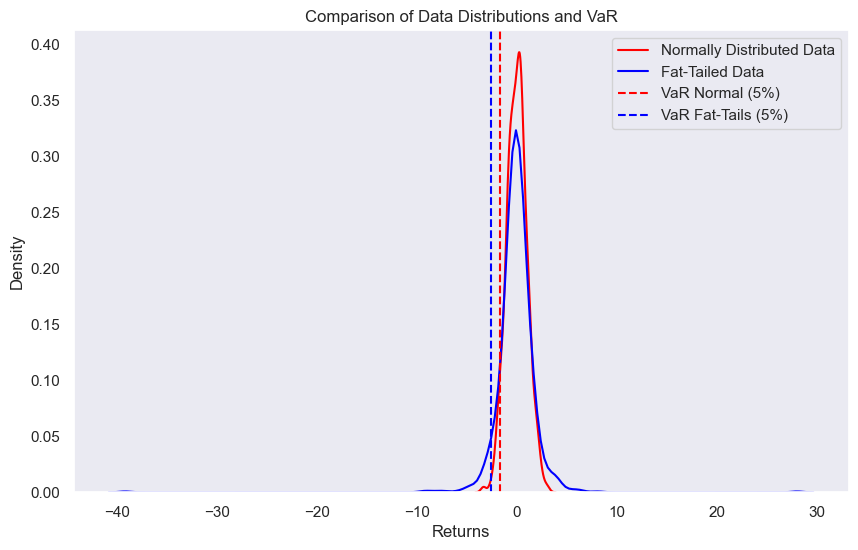

In [9]:
# Plotting both distributions and VaRs
plt.figure(figsize=(10, 6))

sns.kdeplot(data_normal, label='Normally Distributed Data', color='red')
sns.kdeplot(data_fat_tails, label='Fat-Tailed Data', color='blue')

plt.axvline(x=VaR_normal, color='red', linestyle='--', label=f'VaR Normal ({VaR_level}%)')
plt.axvline(x=VaR_fat_tails, color='blue', linestyle='--', label=f'VaR Fat-Tails ({VaR_level}%)')

plt.title('Comparison of Data Distributions and VaR')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()

plt.show()


### **Poor Model Specification**

A model that assumes normality for non-normal underlying data will suffer from poor specification, meaning there are systematic errors in parameter estimates. This can make the conclusions drawn from the model biased.

A poor goodness of fit can be inspected visually by comparing the actual and the normal distributions KDE, or by the Q-Q plot. This has been done previously in this analysis. 

Numerically, both  Shapiro-Wilk test and Anderson-Darling test are goodness of fit tests. Rejecting the null hypothesis in both of these test means that the data does not come from a normal distribution.

## **Direction**

### **Transformations**

One way to account for non-normality in the underlying data is to apply transformations that make the distribution closer to normal. Using logarithmic and square root transformations is common to reduce right skewness. A more generalized transformation is **Box-Cox Transformation** which finds the best power transformation to approximate normality.

If the data is left skewed, the inverse transformation is useful.

To demonstrate this approach on the fat-tailed data, The analysis applies the Yeo-Johnson transformation, which can be used when the data has both positive and negative values.

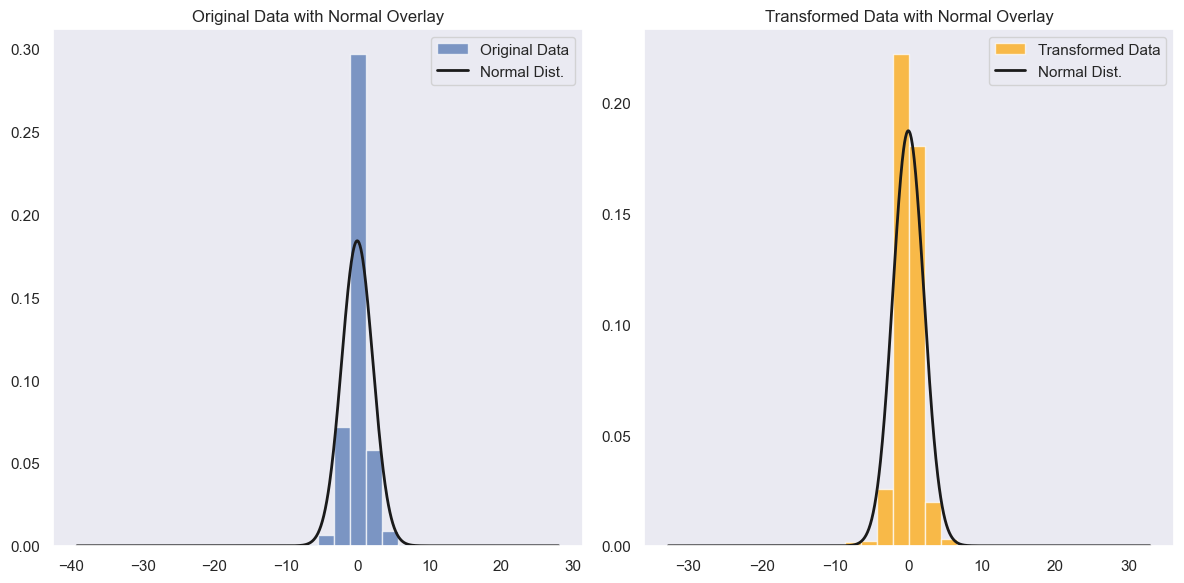

In [10]:
# Applying Yeo-Johnson transformation
data_transformed, _ = stats.yeojohnson(data_fat_tails)

# Calculating parameters for the normal distribution overlay
mean_transformed, std_transformed = np.mean(data_transformed), np.std(data_transformed)

# Generating points for the normal distribution
x_transformed = np.linspace(min(data_transformed), max(data_transformed), 1000)
pdf_transformed = stats.norm.pdf(x_transformed, mean_transformed, std_transformed)

# Plotting the original and transformed data distributions with normal distribution overlay
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(data_fat_tails, bins=30, alpha=0.7, density=True, label='Original Data')
# Overlay of normal distribution for original data (for demonstration, using empirical mean and std)
mean_original, std_original = np.mean(data_fat_tails), np.std(data_fat_tails)
x_original = np.linspace(min(data_fat_tails), max(data_fat_tails), 1000)
pdf_original = stats.norm.pdf(x_original, mean_original, std_original)
plt.plot(x_original, pdf_original, 'k-', linewidth=2, label='Normal Dist.')
plt.title("Original Data with Normal Overlay")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(data_transformed, bins=30, alpha=0.7, density=True, color='orange', label='Transformed Data')
plt.plot(x_transformed, pdf_transformed, 'k-', linewidth=2, label='Normal Dist.')
plt.title("Transformed Data with Normal Overlay")
plt.legend()

plt.tight_layout()
plt.show()


The new distribution now has thinner tails. 

### **Nonparametric Statistical Methods**

These are statistical methods that do not assume a specific distribution for the data, which make them useful when it is not possible to rely on the normality assumption (e.g., financial or economic times series) [[8]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4754273/#:~:text=Nonparametric%20statistical%20analysis%20greatly%20differs,of%20the%20data%20per%20se.).

**Examples of these methods are:**
- **Kruskal-Wallis test** for comparing more than two groups.
- **Mann-Whitney U test** for comparing two groups.
- **Spearman's rank correlation** instead of Pearson's correlation for analyzing relationships between variables.

As an example, the following code uses Mann-Whitney U test to test whether there is a difference in the central tendency between the two halves of the fat-tailed dataset.


In [11]:
# Splitting the fat-tailed dataset into two groups
group_A = data_fat_tails[:500]
group_B = data_fat_tails[500:]

# Perform the Mann-Whitney U Test
u_statistic, p_value = stats.mannwhitneyu(group_A, group_B)

print(f"Mann-Whitney U test results:\nU Statistic: {u_statistic}, P-value: {p_value}")

# Decision based on p-value
if p_value < 0.05:
    print("Decision: Reject the null hypothesis. There is a significant difference in the central tendency between the two groups.")
else:
    print("Decision: Fail to reject the null hypothesis. There is not a significant difference in the central tendency between the two groups.")


Mann-Whitney U test results:
U Statistic: 124622.0, P-value: 0.9341180872006426
Decision: Fail to reject the null hypothesis. There is not a significant difference in the central tendency between the two groups.


### **Robust Statistical Methods**

These are statistical methods that are designed to be less sensitive to outliers, which maker them more reliable if the data deviates from normality.

**Examples of these methods are:**
- **Robust Descriptive Statistics**, such as the median, interquartile range (IQR), and trimmed means.
- **Robust Regression Techniques**, such as least absolute shrinkage and selection operator (LASSO).

The following code runs a Robust Linear Regression on the fat-tailed data.

In [12]:
data_fat_tails.shape

(1000,)

In [13]:
# Prepare data for robust regression
X = data_normal
y = data_fat_tails
X = sm.add_constant(X)  # Adds a constant term to the predictor

# Fit a robust linear model
rlm_model = RLM(y, X, M=sm.robust.norms.HuberT())
rlm_results = rlm_model.fit()

print("Robust linear regression results:")
print(rlm_results.summary())

Robust linear regression results:
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                 1000
Model:                            RLM   Df Residuals:                      998
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 26 Mar 2024                                         
Time:                        14:43:32                                         
No. Iterations:                    14                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0

### **Machine Learning Techniques**

There are some advanced machine learning techniques that do not require assume of normality, which make them suitable when reliance on normality can be misguiding. Examples of these techniques are random forests, support vector machines (SVM), and neural networks.

## **References**

1.	Schmidt, A F., and Chris Finan. “Linear Regression and the Normality Assumption.” Institute of Cardiovascular Science, Faculty of Population Health, University College London, University College London, WC1E 6BT, United Kingdom, https://discovery.ucl.ac.uk/id/eprint/10070182/1/Schmidt_UCL_depos_JCE2018.pdf

2.	Nair, Sujith Jay. “The Assumption of Normality in Time Series.” sujithjay.com, https://sujithjay.com/normality-assumption

3.	Theodossiou, Panayiotis. “Financial Data and the Skewed Generalized T Distribution.” Management Science, vol. 44, Dec. 1998, pp. 1650-1661. Social Science Research Network, https://papers.ssrn.com/sol3/papers.cfm?abstract_id=65037

4.	Ghasemi, Asghar, and Saleh Zahediasl. “Normality Tests for Statistical Analysis: A Guide for Non-Statisticians.” International Journal of Endocrinology and Metabolism, vol. 10, no. 2, Spring 2012, pp. 486–489, doi:10.5812/ijem.3505. PubMed Central, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3693611/

5.	Thadewald, Thorsten, and Herbert Büning. “Jarque-Bera Test and Its Competitors for Testing Normality: A Power Comparison.” Diskussionsbeiträge, no. 2004/9, Free University Berlin, School of Business & Economics, 2004. EconStor, https://www.econstor.eu/bitstream/10419/49919/1/668828234.pdf

6.	Malato, Gianluca. “An Introduction to the Shapiro-Wilk Test for Normality.” Built In, 2 May 2023, https://builtin.com/data-science/shapiro-wilk-test

7.	“Anderson-Darling Test.” National Institute of Standards and Technology, https://www.itl.nist.gov/div898/handbook/eda/section3/eda35e.htm

8.	Nahm, Francis Sahngun. “Nonparametric Statistical Tests for the Continuous Data: The Basic Concept and the Practical Use.” Korean Journal of Anesthesiology, vol. 69, no. 1, Feb. 2016, pp. 8–14, doi:10.4097/kjae.2016.69.1.8. PubMed Central, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4754273/
